In [3]:
Обучить AE собственной архитектуры на MNIST

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
input_channels = 1
hidden_channels = 250
batch_size = 128
device = torch.device('cuda')
n_epochs = 3

In [3]:


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)
     

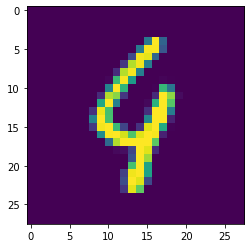

In [4]:
dataset_test


plt.imshow(dataset_test.data[115].detach().numpy())
plt.show()
          

In [5]:
class ConvEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)   
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    self.do3 = nn.Dropout(dropout_p)
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.bn4 = nn.BatchNorm2d(hidden_ch)
    self.do4 = nn.Dropout(dropout_p)

    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv5 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1,   
                           padding=1) # 7x7
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do2(self.activ(self.bn2(self.conv2(self.do1(self.activ(self.bn1(self.conv1(x)))))))))
    x = self.pool2(self.do4(self.activ(self.bn4(self.conv4(self.do3(self.activ(self.bn3(self.conv3(x)))))))))
    x = self.conv5(x)

    return x

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14       
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    self.do3 = nn.Dropout(dropout_p)
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.bn4 = nn.BatchNorm2d(hidden_ch)
    self.do4 = nn.Dropout(dropout_p)

    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv5 = nn.Conv2d(hidden_ch, input_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.activ = nn.ReLU()
  def forward(self, x):
    x = self.upsample1(self.do2(self.activ(self.bn2(self.conv2(self.do1(self.activ(self.bn1(self.conv1(x)))))))))
    x = self.upsample2(self.do4(self.activ(self.bn4(self.conv4(self.do3(self.activ(self.bn3(self.conv3(x)))))))))
    x = self.conv5(x)


    return x

class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_




In [6]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() 

epoch: 0, step: 0, loss: 1.2538172006607056
epoch: 0, step: 200, loss: 0.0601598359644413
epoch: 0, step: 400, loss: 0.045527443289756775


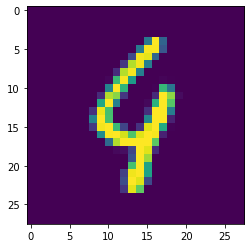

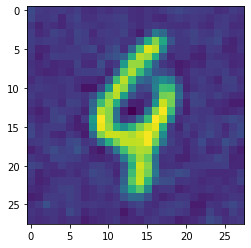

epoch: 1, step: 0, loss: 0.03881563991308212
epoch: 1, step: 200, loss: 0.03208649158477783
epoch: 1, step: 400, loss: 0.02819274365901947


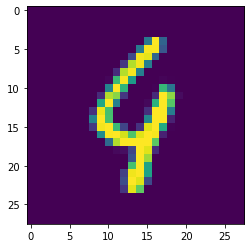

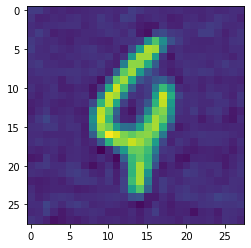

epoch: 2, step: 0, loss: 0.03286898136138916
epoch: 2, step: 200, loss: 0.029925629496574402
epoch: 2, step: 400, loss: 0.02613566815853119


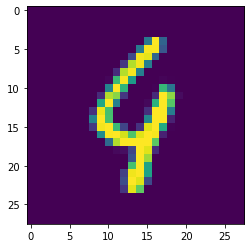

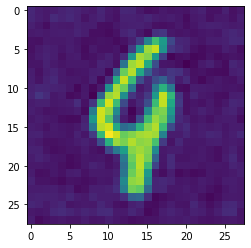

Wall time: 4min 12s


In [7]:
%%time
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[115][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[115][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./conv_ae_chkpt_{epoch}.pth')
     

In [ ]:
Обучить VAE собственной архитектуры на MNIST

In [8]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)   
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    self.do3 = nn.Dropout(dropout_p)
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.bn4 = nn.BatchNorm2d(hidden_ch)
    self.do4 = nn.Dropout(dropout_p)

    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv5_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    self.conv5_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do2(self.activ(self.bn2(self.conv2(self.do1(self.activ(self.bn1(self.conv1(x)))))))))
    x = self.pool2(self.do4(self.activ(self.bn4(self.conv4(self.do3(self.activ(self.bn3(self.conv3(x)))))))))
    mu = self.conv5_mu(x)
    sigma = torch.exp(self.conv5_sigma(x))

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14       
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    self.do3 = nn.Dropout(dropout_p)
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.bn4 = nn.BatchNorm2d(hidden_ch)
    self.do4 = nn.Dropout(dropout_p)

    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv5 = nn.Conv2d(hidden_ch, input_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.activ = nn.ReLU()
  def forward(self, x):
    x = self.upsample1(self.do2(self.activ(self.bn2(self.conv2(self.do1(self.activ(self.bn1(self.conv1(x)))))))))
    x = self.upsample2(self.do4(self.activ(self.bn4(self.conv4(self.do3(self.activ(self.bn3(self.conv3(x)))))))))
    x = self.conv5(x)


    return x


def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)


    return x_, mu, sigma
     
     

In [9]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() 



epoch: 0, step: 0, loss: 1.0373990535736084
epoch: 0, step: 200, loss: 0.1159057468175888
epoch: 0, step: 400, loss: 0.07890909910202026


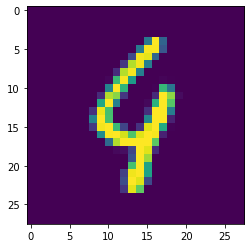

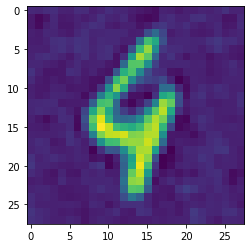

epoch: 1, step: 0, loss: 0.07075028866529465
epoch: 1, step: 200, loss: 0.06164446473121643
epoch: 1, step: 400, loss: 0.05841507017612457


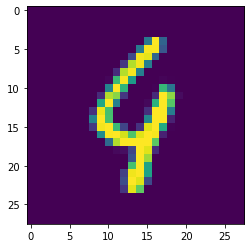

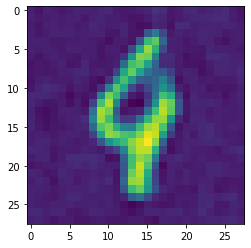

epoch: 2, step: 0, loss: 0.054115183651447296
epoch: 2, step: 200, loss: 0.0520801767706871
epoch: 2, step: 400, loss: 0.0484381802380085


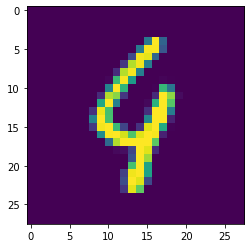

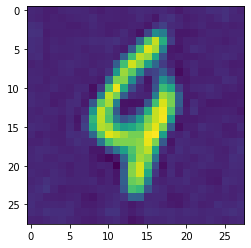

Wall time: 4min 15s


In [10]:
%%time
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        predict, mu, sigma = model(inputs)
        loss = loss_func(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[115][0].unsqueeze(0).to(device).float()
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item)[0].squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')